In [1]:
import os, sys
from collections import OrderedDict
import cv2
import numpy as np
import torch
from detectron2.data.build import build_detection_test_loader, build_detection_train_loader
from detectron2.config import get_cfg
from detectron2.modeling.meta_arch import build_model
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures.image_list import ImageList
%cd "../"
%pwd

from fcsgg.config import add_fcsgg_config
# customized dataset mapper
from fcsgg.data.dataset_mapper import DatasetMapper
from fcsgg.config import add_fcsgg_config
from fcsgg.data.detection_utils import GroundTruthGen
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["xtick.bottom"] = False
plt.rcParams["xtick.labelbottom"] = False
plt.rcParams["ytick.left"] = False
plt.rcParams["ytick.labelleft"] = False
plt.rcParams["font.size"] = 16 
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
def setup():
    """
    Create configs return it.
    """
    config_file = "configs/quick_schedules/Quick-FCSGG-HRNet.yaml"
    cfg = get_cfg()
    add_fcsgg_config(cfg)
    cfg.merge_from_file(config_file)
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.DATALOADER.NUM_WORKERS = 0
    cfg.freeze()
    return cfg
cfg = setup()
dataloader = build_detection_train_loader(cfg, mapper=DatasetMapper(cfg, True))
dataset_metadata = MetadataCatalog.get("vg_train")
gt_gen = GroundTruthGen(cfg)

/Users/henry/Research/fcsgg


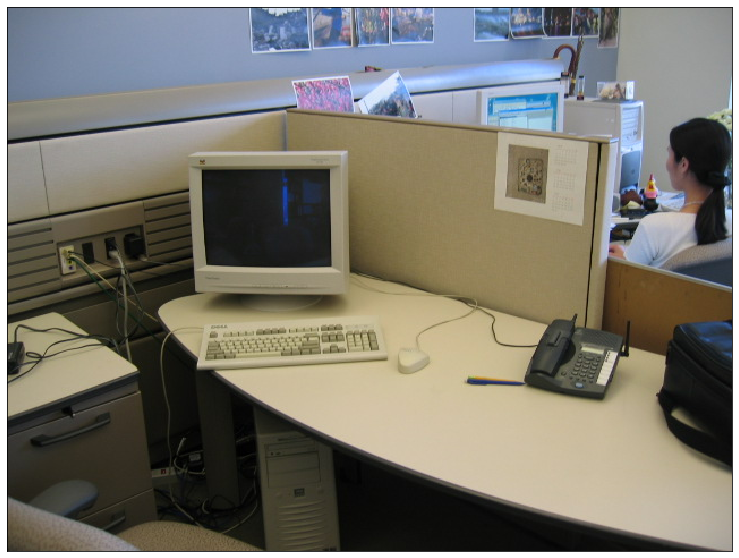

In [2]:
d = next(iter(dataloader))[0]
im = cv2.imread(d["file_name"])
plt.imshow(im[:, :, ::-1])
plt.show()

# for d in dataloader:
#     d = d[0]
# #     print(d["file_name"])
#     if d["file_name"] == "datasets/vg/VG_100K/2364731.jpg":
#         im = cv2.imread(d["file_name"])
#         plt.imshow(im[:, :, ::-1])
#         plt.show()
#         break

In [3]:
print(d["file_name"])

datasets/vg/VG_100K/3.jpg


padding size: ((0, 0), (0, 0), (0, 0))
feature size: (150, 60, 80)
image size: (480, 640)
19 has
49 with


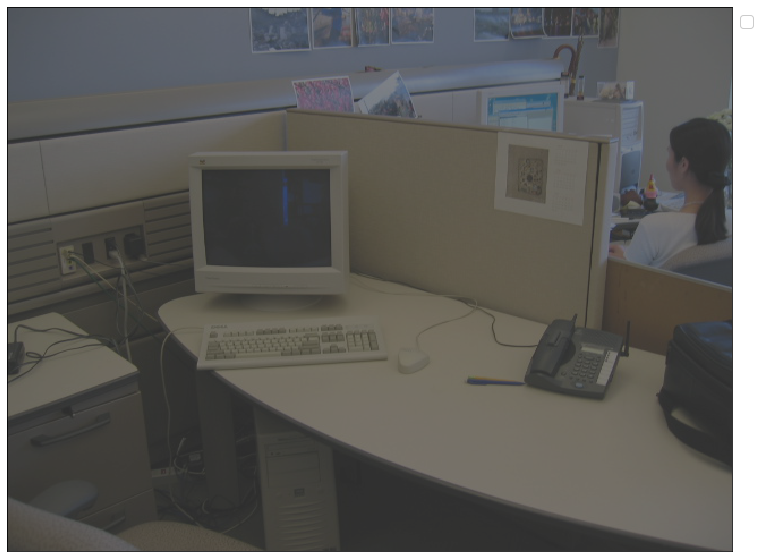

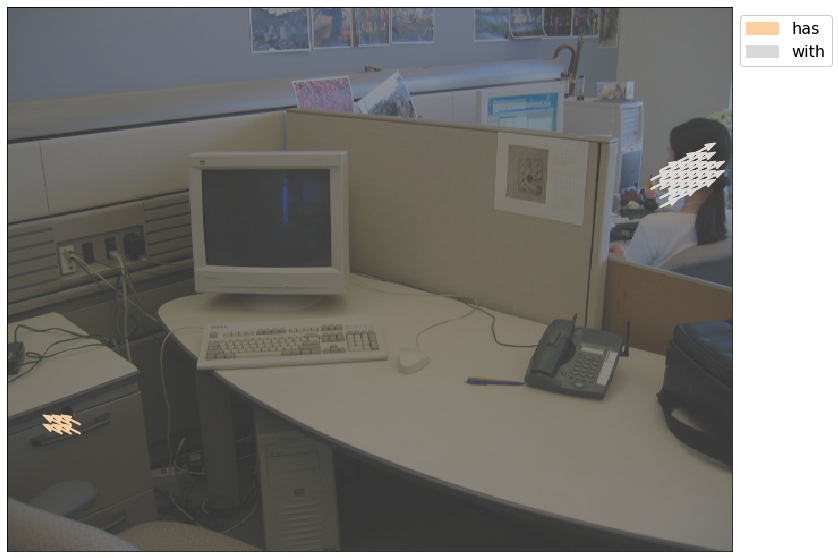

In [8]:
add_ignore = False
predicate_classes = dataset_metadata.predicate_classes
object_classes = dataset_metadata.thing_classes
object_cmaps = plt.cm.get_cmap('tab20', len(object_classes))
scale = 0
stride = cfg.MODEL.HEADS.OUTPUT_STRIDES[scale]
image_padded = ImageList.from_tensors([d["image"]], 0).tensor[0].numpy() # (3, H, W)
_, H, W = image_padded.shape
sg = gt_gen(d['scene_graph'], (H, W))
gt_center_maps = sg[scale].gt_ct_maps.numpy() # (C, h, w)
gt_classes = sg[scale].gt_classes.numpy()
c, h_, w_ = gt_center_maps.shape
h, w = H // stride, W // stride
padding_size = ((0, 0), (0, h - h_), (0, w - w_))
gt_center_maps = np.pad(gt_center_maps, padding_size, constant_values=-1 if add_ignore else 0)
print("padding size: {}".format(padding_size))
print("feature size: {}".format(gt_center_maps.shape))
print("image size: {}".format((H, W)))

# for i, map in enumerate(gt_center_maps):
#     if add_ignore:
#         if np.mean(map) != -1:
#             plt.figure()
#             plt.imshow(map)
#     else:
#         if np.mean(map) != 0:
#             plt.figure()
#             plt.imshow(map)
maps = []
for i in range(c):
    maps.append(cv2.resize(gt_center_maps[i], (W, H)))
# gt_center_maps = np.stack(maps, axis=-1)
# gt_center_maps = np.max(gt_center_maps, axis=-1)
image_padded = np.transpose(image_padded, (1,2,0))
# gt_center_maps = cv2.cvtColor(gt_center_maps, cv2.COLOR_GRAY2RGB)
# out = cv2.addWeighted(image_padded.astype(np.float32), 0.6, gt_center_maps * 255.0, 1.0, 0).astype(np.int32)
# out = np.clip(out, 0, 255)
# plt.figure()
# plt.imshow(out[:, :, ::-1])

############## centers + bounding boxes #############
image_padded = (image_padded * 0.5 + 64).astype(np.uint8)
image = (image_padded.copy() * 1.0).astype(np.uint8)
gt_wh = sg[scale].gt_wh.numpy()
gt_wh = np.clip(gt_wh, (0, 0), (w_-1, h_-1))
gt_wh = gt_wh * stride
gt_centers_int = sg[scale].gt_centers_int.numpy()
gt_index = gt_centers_int[...,1] * w + gt_centers_int[...,0]
gt_reg = sg[scale].gt_reg.numpy()
y = gt_index // w
x = gt_index % w
centers = np.stack((x, y), axis=-1)

points = (gt_reg + centers) * stride
points_int = np.floor(points).astype(np.int32)
# for p in points_int:
#     cv2.circle(image, tuple(p), 5, (0, 0, 255), -1)


top_left_coord = np.floor(points - gt_wh / 2).astype(int)
bottom_right_coord = np.floor(points + gt_wh / 2).astype(int)

top_left_coord = np.clip(top_left_coord, (0, 0), (W - 1, H - 1))
bottom_right_coord = np.clip(bottom_right_coord, (0, 0), (W - 1, H - 1))
obj_patches = {}

center_map_image = np.zeros_like(image)
for cls_id, ct_map in enumerate(maps):
    color = object_cmaps(cls_id / len(object_classes))[:3]
    color_255 = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
    center_maps_i = (np.repeat(np.expand_dims(ct_map, axis=2), 3, axis=2) * \
                        np.array(color_255)[np.newaxis, np.newaxis, :]).astype(np.uint8)
    center_map_image = cv2.addWeighted(center_map_image, 1.0, center_maps_i, 0.5, 0)
teaser_objects = cv2.addWeighted(image, 0.7, center_map_image, 0.8, 0)

f = plt.figure()
ax = plt.gca()
for i, (p, wh) in enumerate(zip(top_left_coord, gt_wh)):
    color = object_cmaps(gt_classes[i] / len(object_classes))[:3]
    color_255 = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
#     cv2.rectangle(image, tuple(p1), tuple(p2), color_255, 2)
    rect = matplotlib.patches.Rectangle((p[0], p[1]), wh[0], wh[1],linewidth=3,
                                        edgecolor=color,facecolor='none', alpha=0.9)
    ax.add_patch(rect)
    patch = matplotlib.patches.Patch(color=color, label=object_classes[gt_classes[i]])
    if gt_classes[i] not in obj_patches:
#         print(gt_classes[i])
        obj_patches[gt_classes[i]] = patch

plt.imshow(teaser_objects[:, :, ::-1])
plt.legend(handles=list(obj_patches.values()), framealpha=1, bbox_to_anchor=(1.0, 1), loc='upper left')
# f.savefig("./teaser_objects.pdf", bbox_inches='tight')


gt_relations = sg[scale].gt_relations.numpy()
gt_relations = np.pad(gt_relations, ((0,0),) + padding_size)
# concat_gt_relations = torch.sum(gt_relations, dim=0).numpy()
# print(concat_gt_relations)
def visualize_paf(img, pafs, name='pafs', display_stride_x=2, display_stride_y=2, alpha=0.8):
#     display_stride = max(8 // display_stride, 1)
    f = plt.figure()
    num_predicates = pafs.shape[0]
    cmap = plt.cm.get_cmap('tab20c', num_predicates)
    overlay = img.copy()
    p_classes = []

    for i in range(num_predicates):
        color = cmap(i / num_predicates)[:3]
        color_255 = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
        paf_x = pafs[i,0,:,:]
        paf_y = pafs[i,1,:,:]
        len_paf = np.sqrt(paf_x**2 + paf_y**2)
        if len_paf.sum() > 0:
            print(i, predicate_classes[i])
            patch = matplotlib.patches.Patch(color=color, label=predicate_classes[i])
            p_classes.append(patch)
            for y in range(0,len_paf.shape[0], display_stride_y):
                for x in range(0, len_paf.shape[1], display_stride_x):
                    if len_paf[y, x]>0.0:
                        plt.arrow(x * stride, y * stride, 10 * paf_x[y,x], 10 * paf_y[y,x],
                                  width=1, head_width=6, color=color, alpha=1.0)
#                         cv2.arrowedLine(overlay, (int(x-0.5) * stride, int(y-0.5) * stride), (int((x-0.5)*stride + 12*paf_x[y,x]), 
#                                                      int((y-0.5)*stride + 12*paf_y[y,x])), 
#                                         color_255, 2, tipLength=0.4, line_type=cv2.LINE_AA)
            
    overlay = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    
    plt.imshow(overlay[:, :, ::-1])
    plt.legend(handles=p_classes, framealpha=1, bbox_to_anchor=(1.0, 1), loc='upper left')
#     f.savefig("./teaser_rafs.pdf", bbox_inches='tight')


teaser_rafs = cv2.addWeighted(image, 0.8, center_map_image, 0.4, 0)
triplets = sg[scale].get_extra('gt_relations').numpy()
# print(centers[triplets[:, 0]])
visualize_paf(teaser_rafs, gt_relations, display_stride_x=1, display_stride_y=1)

In [5]:
# def test(img, rafs, centers, triplets, integral_length=100, stride=16, alpha=0.9):
#     f = plt.figure()
#     cmap = plt.cm.get_cmap('tab20c', rafs.shape[0])
#     overlay = img.copy()
#     p_classes = {}
#     subj_centers = centers[triplets[:, 0]]
#     obj_centers = centers[triplets[:, 1]]
#     predicates = triplets[:, 2]
#     N = predicates.shape[0]
# #     integral_space = np.linspace(subj_centers, obj_centers, num=integral_length, endpoint=False)
# #     integral_space = np.rint(integral_space).astype(np.int32).transpose(1, 0, 2)
#     len_paf = np.linalg.norm(rafs, axis=1)
#     norms = np.linalg.norm(subj_centers - obj_centers, axis=1)
#     factors = np.max(norms) / norms
#     print(factors)
# #     print(integral_space.shape)
#     for i in range(N):
# #         integral_line = np.unique(integral_space[i], axis=0)
#         integral_length = np.linalg.norm(subj_centers[i] - obj_centers[i])
# #         integral_length = np.clip(integral_length, 1, 100)
#         integral_length = integral_length.astype(np.int32)
#         integral_line = np.linspace(subj_centers[i], obj_centers[i], num=integral_length, endpoint=False)
#         integral_line = np.rint(integral_line).astype(np.int32)
# #         integral_line = np.unique(integral_line, axis=0)
# #         print(integral_line.shape)
#         predicate = predicates[i]
#         color = cmap(predicate / rafs.shape[0])[:3]
#         color_255 = (int(color[2] * 255), int(color[1] * 255), int(color[0] * 255))
#         patch = matplotlib.patches.Patch(color=color, label=predicate_classes[predicate])
#         if predicate not in p_classes:
#             p_classes[predicate] = patch
#         for j in range(0, integral_line.shape[0]-1, int(max(factors[i] * integral_length // stride , 1))):
#             x, y = integral_line[j]
#             if len_paf[predicate, y, x]>0.0:
#                         plt.arrow(x, y, 8 * rafs[predicate,0,y,x], 8 * rafs[predicate,1,y,x],
#                                   width=2, head_width=6, color=color, alpha=1.0)
#     overlay = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
    
#     plt.imshow(overlay[:, :, ::-1])
#     plt.legend(handles=p_classes.values(), framealpha=1, bbox_to_anchor=(1.0, 1), loc='upper left')
# #     f.savefig("./teaser_rafs.pdf", bbox_inches='tight')
    
# print(centers.shape)
# teaser_rafs = cv2.addWeighted(image, 0.7, center_map_image, 0.6, 0)
# test(teaser_rafs, gt_relations, centers, triplets)
    
    

tensor([[ 1,  3, 19],
        [ 1,  3, 49],
        [ 2,  0, 30],
        [ 7,  5, 19]])
1.0


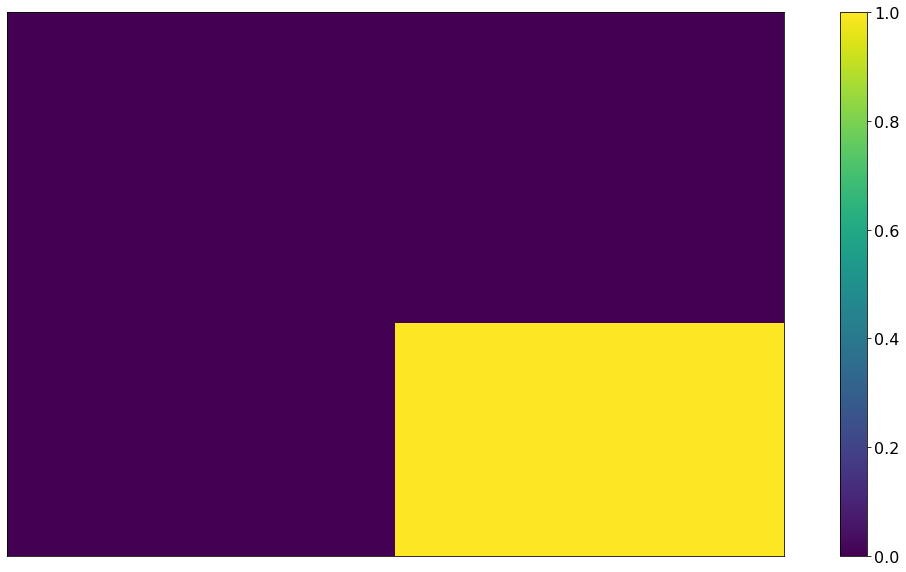

In [6]:
relation_norms = np.linalg.norm(gt_relations, axis=1)
# print(relation_norms.shape)

print(sg[scale].get_extra('gt_relations'))

for rel_norm in relation_norms:
    if rel_norm.sum() > 0:
        print(rel_norm.max())
        plt.figure()
        plt.imshow(rel_norm)
        plt.colorbar()

30


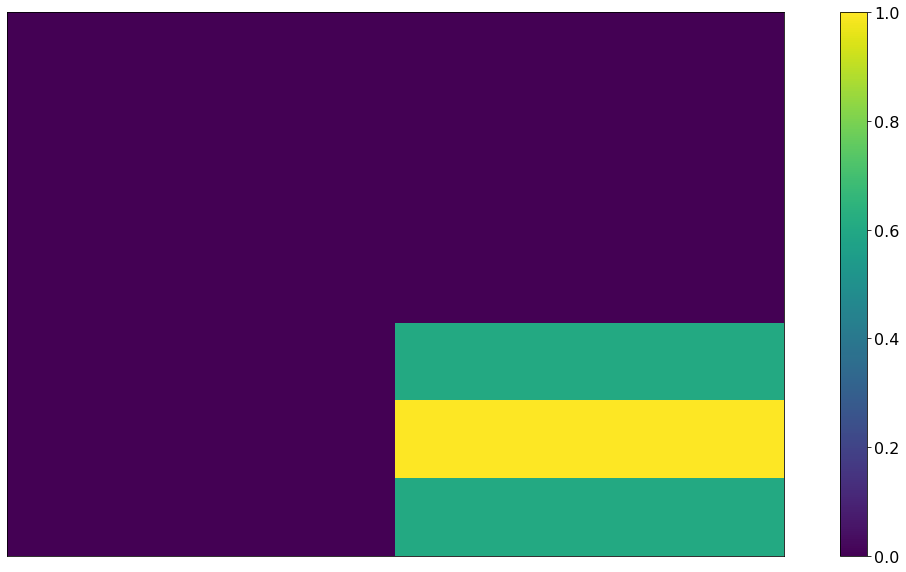

In [7]:
gt_relation_weights = sg[scale].gt_relations_weights.numpy()
# plt.figure()
# plt.imshow(gt_relation_weights)
# plt.colorbar()
relation_weight_norms = np.linalg.norm(gt_relation_weights, axis=1)
for i, rel_weight_norm in enumerate(relation_weight_norms):
    if rel_weight_norm.sum() != 0:
        print(i)
        plt.figure()
        plt.imshow(gt_relation_weights[i, 1])
        plt.colorbar()